In [ ]:
#default_exp callback.bs_finder

In [ ]:
#export
from fastai2.basics import *

In [ ]:
from nbdev.showdoc import *

# Batch size finder callback
> Callback to apply [An Empirical Model of Large-Batch Training](https://arxiv.org/pdf/1812.06162.pdf) to find the optimal batch size to minimaze the training time. 

Be aware that this batch size  may not be a the best one to minimize the validation loss. From the paper:
> Some papers have reported a “generalizaion gap” in which large batch sizes lead to good training loss but cause a degradation in test loss, apparently unrelated to overfitting. 

Althought, also from the paper:
> ... but recent work has found no evidence of a generalization gap when hyperparameters are properly tuned.

See section 2.4 "Assumptions and Caveats" from the research paper for more caveats of this method. 


Helper functions

In [ ]:
#export
# Linear combination for the moving average
def _lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2


def _ema_with_debias(avg, beta, yi, i):
    "Exponential moving average with debiasing"
    if avg is None: avg=0
    avg = _lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))


def _get_flatten_grads(model):
    parameters = L(model.parameters())
    grads = [param.grad.flatten().view(-1,1) for param in parameters if not type(param.grad) == type(None)]
    grad = torch.cat(grads)
    return grad    

The callback itself

In [ ]:
#export
class BSFinder(Callback):
    "A `Callback` that implements \"An Empirical Model of Large-Batch Training\" (https://arxiv.org/abs/1812.06162)"
    run_after=Recorder
    
    def __init__(self, num_it:int=None, n_batch=5, beta=0.99, simulate_multi_gpus=True): 
        store_attr(self, 'num_it, n_batch, beta, simulate_multi_gpus')

    def begin_fit(self):
        # Save original model
        self.learn.save('_tmp')
        
        if not self.num_it: self.num_it = len(self.dls.train) * (self.n_batch if self.simulate_multi_gpus else 1)
        
        self.running_scale = None
        self.running_noise = None
        
        # Use python list instead L fastai list as torch.cat doesn't understand the former
        self.stored_grads = []

        # Here, we will store the results
        self.stats = L()
        self.count=0

    def begin_validate(self): raise CancelValidException()
                
    def after_backward(self):  
        if self.train_iter >= self.num_it: raise CancelFitException()
               
        # Get gradients and store them
        self.stored_grads.append(_get_flatten_grads(self.model))
        
        self.count += 1
        if self.count != len(self.stored_grads):
            breakpoint()

        if self.simulate_multi_gpus and len(self.stored_grads) < self.n_batch: 
            self.opt.zero_grad() # Zero gradients to avoid acumulate them between batches
            #print('a', self.count, self.train_iter, learn.model.embeds[0].weight[0][:3].tolist())
            raise CancelBatchException() #skip weight update
        
        if len(self.stored_grads) == self.n_batch: 
            self.count=0
            #print('b', self.count, self.train_iter, learn.model.embeds[0].weight[0][:3].tolist())
            # We have enough batches to compute Simple Noise Scale ratio.
            
            # We concatenate the batches and empty the buffer
            stored_grads = torch.cat(self.stored_grads, dim=1)
            self.stored_grads.clear()
            
            acc_grads = stored_grads.mean(dim = 1)
        
            # The original implementation uses .mean() although in the original article didn't do it. However, averaging g_big and g_small doesn't affect to noise_scale ratio 
            if self.simulate_multi_gpus: g_small = (stored_grads ** 2).sum(dim=0).mean() 
            else: g_small = (stored_grads[:,-1] ** 2).sum() # .mean()
                
            # print((stored_grads ** 2).sum(dim=0).mean().item(), (stored_grads[:,-1] ** 2).sum().item(), (stored_grads ** 2).sum(dim=0).tolist())
            
            g_big = (acc_grads ** 2).sum() # .mean()
            
            bs = find_bs(self.yb) # or self.dls.train.bs
            b_small, b_big = bs, bs * self.n_batch
        
            noise = (b_big * g_big - b_small * g_small) / (b_big - b_small)
            scale = (g_small - g_big) / ((1 / b_small) - (1 / b_big))

            self.running_scale, scale = _ema_with_debias(self.running_scale,self.beta,scale,self.iter)
            self.running_noise, noise = _ema_with_debias(self.running_noise,self.beta,noise,self.iter)

            scale = scale.item()
            noise = noise.item()
            noise_scale = (scale / noise)
            
            # Save results
            self.stats.append(dict(n_iter=(len(self.stats)) * (1 if self.simulate_multi_gpus else self.n_batch),
                                   noise=noise, scale=scale, noise_scale=noise_scale))
        
    def after_fit(self):
        if self.train_iter < self.num_it: warn(f"Fitting was too short to complete all expectediterations. Please, increase the number of epochs")
            
        tmp_f = self.path/self.model_dir/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load('_tmp')
            os.remove(tmp_f)
        
        if hasattr(self.learn, 'recorder'): 
            # index = pd.Index(torch.arange(1, len(self.stats)+1)*self.n_batch, name='n_iter')
            df = pd.DataFrame(self.stats)#, index=index)
            df.set_index('n_iter', inplace=True)
            self.recorder.bs_find_stats = df
    
    _docs = {"begin_fit": "Initialize container for search results and auxiliary variables and save the model",
             "after_fit": "Record hyper-parameters of this batch and potentially stop training",
             "after_backward": "Store gradients and compute Simple Noise Scale",
             "begin_validate": "Skip the validation part of training"}
        

In [ ]:
add_docs(BSFinder, **BSFinder._docs)

In [ ]:
show_doc(BSFinder.begin_fit)

<h4 id="BSFinder.begin_fit" class="doc_header"><code>BSFinder.begin_fit</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>BSFinder.begin_fit</code>()

Initialize container for search results and auxiliary variables and save the model

In [ ]:
show_doc(BSFinder.after_fit)

<h4 id="BSFinder.after_fit" class="doc_header"><code>BSFinder.after_fit</code><a href="__main__.py#L78" class="source_link" style="float:right">[source]</a></h4>

> <code>BSFinder.after_fit</code>()

Record hyper-parameters of this batch and potentially stop training

In [ ]:
show_doc(BSFinder.after_backward)

<h4 id="BSFinder.after_backward" class="doc_header"><code>BSFinder.after_backward</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>BSFinder.after_backward</code>()

Store gradients and compute Simple Noise Scale

In [ ]:
show_doc(BSFinder.begin_validate)

<h4 id="BSFinder.begin_validate" class="doc_header"><code>BSFinder.begin_validate</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>BSFinder.begin_validate</code>()

Skip the validation part of training

Methods for `Recorder` and `Learner` classes related to `BSFinder` callback. 

In [ ]:
#export
@patch
def plot_bs_find(self:Recorder):
    "Plot the result of an BS Finder test (won't work if you didn't do `learn.bs_find()` before)"
    fig, ax = plt.subplots(1,1)
    stats = self.bs_find_stats
    ax.plot(stats.index, stats.noise_scale)
    ax.set_ylabel("Simple Noise Scale")
    ax.set_xlabel("# iteration")

In [ ]:
#export
@delegates(BSFinder)
@patch
def bs_find(self:Learner, lr, num_it=None, n_batch=5, simulate_multi_gpus=True, show_plot=True, **kwargs):
    """
    Launch a mock training to find a good batch size to minimaze training time. 
    However, it may not be a good batch size to minimize the validation loss. 
    
    A good batch size is where the Simple Noise Scale converge ignoring the small growing trend 
    with the number of iterations if exists. The optimal batch size is about an order the magnitud
    where Simple Noise scale converge. Typically,  the optimial batch size in image classification 
    problems will be 2-3 times lower where 
    """  
    num_it = num_it if num_it else len(self.dls.train)
    num_it *= n_batch if simulate_multi_gpus else 1
    n_epoch = num_it//len(self.dls.train)
    cb=BSFinder(num_it=num_it, n_batch=n_batch, simulate_multi_gpus=simulate_multi_gpus, **kwargs)
    with self.no_logging(): self.fit(n_epoch, lr, cbs=cb)
    if show_plot: self.recorder.plot_bs_find()

In [ ]:
show_doc(BSFinder)

<h2 id="BSFinder" class="doc_header"><code>class</code> <code>BSFinder</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>BSFinder</code>(**`num_it`**:`int`=*`None`*, **`n_batch`**=*`5`*, **`beta`**=*`0.99`*, **`simulate_multi_gpus`**=*`True`*) :: [`Callback`](/callback.core#Callback)

A [`Callback`](/callback.core#Callback) that implements "An Empirical Model of Large-Batch Training" (https://arxiv.org/abs/1812.06162)

`num_it` is the number of batches you want to process. It can be set to `None` and it will automatically train during one epoch (or `n_batch` if `simulate_multi_gpus` is set to `True`). `n_batch` is the number of batches you want to store before computing the Simple Noise Scale. 5 to 20 seems to work well across different tasks.

`beta` is the beta parameter for an exponential moving average to compute the sum of variances, and the scale of the gradient. If the plot is too irregular, try increasing to 0.999 or more if needed, or increase the `n_batch` parameter.

`simulate_multi_gpus` controls if multi GPU setup is simulated with `n_batch` gpus to match with the original research paper implementation. The multi GPU setup is done by running `n_batch` batches without updating the model weights. Setting it to `False` use [DanyWind aproximation](https://towardsdatascience.com/implementing-a-batch-size-finder-in-fastai-how-to-get-a-4x-speedup-with-better-generalization-813d686f6bdf). It's faster but numerically more inestable and finds a Simple Noise Scale smaller than the original Simple Noise Scale. 

## ¿How to select a good the batch size with `BSFinder` to speed up the training?

1. First, let's quickly create the `dls` where we can use a very big batch size. Here, it doesn't matter which batch size we use
2. Second, find a good learning rate with `Learner.lr_find`.
3. Third, find a good batch size with `Learner.bs_find`. **Remember** that this batch size is optimized for training speed but **not** necessarily to minimaze validation error. Regardless, it gives you a reference to the max batch size to use.
4. Fourth, recreate `dls` with the batch size
5. Fifth, find again a good learning rate with `Learner.lr_find` as usually the best lr depends on the batch size.  

In [ ]:
from fastai2.tabular.all import *

Create the `dls`

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=CategoryBlock(), splits=RandomSplitter()(range_of(df)))

In [ ]:
dls = to.dataloaders()

In [ ]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Federal-gov,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,False,61.000000,136786.999691,10.0,>=50k
1,Private,HS-grad,Widowed,Other-service,Unmarried,White,False,42.000000,153160.001283,9.0,<50k
2,State-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,44.000000,175696.000411,13.0,>=50k
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,Black,False,40.000000,289403.002071,13.0,<50k
4,Private,Bachelors,Divorced,Prof-specialty,Unmarried,White,False,54.999999,80167.004111,13.0,<50k
5,Private,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,False,25.000000,294400.002268,4.0,<50k
6,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,Black,False,43.000000,477983.007414,9.0,<50k
7,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,False,30.000000,426431.006606,14.0,>=50k
8,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,False,51.000000,108435.000619,14.0,>=50k
9,Private,Some-college,Never-married,Sales,Own-child,White,False,19.000001,389142.998699,10.0,<50k


The default batch size is:

In [ ]:
dls.bs

64

Find a good learning rate

In [ ]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

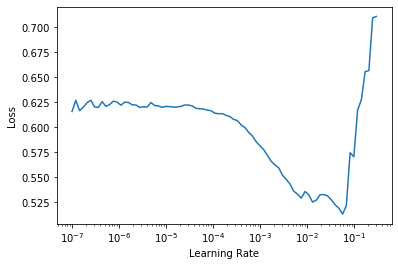

In [ ]:
learn.lr_find(show_plot=False)
learn.recorder.plot_lr_find(skip_end=10)

Find a good batch size.

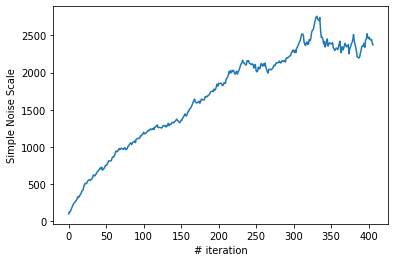

In [ ]:
learn.bs_find(1e-3)

You can also access in the recorder with `Learner.recorder.plot_bs_find()` or access to the raw stats with `Learner.recorder.bs_find_stats`. Here we only show the first rows:

In [ ]:
learn.recorder.bs_find_stats.head()

,noise,scale,noise_scale
n_iter,,,
0,0.967152,95.029655,98.257166
1,0.748730,95.985123,128.197203
2,0.671574,85.072830,126.676711
3,0.564016,84.955147,150.625408
4,0.494141,86.296661,174.639852


A good batch size is were Simple Noise Scale converge. It's expected to exist a small growing trend with the number of iterations. In case that Simple Noise Scale doesn't converge, try to increase `n_batch`. 

In this case, Simple Noise Scale has converged around 2000 or 2500. So a good batch size will be 2048 as they are powers of 2. Again, remember that this batch size is optimized for training speed but **not** to necessarily minimaze validation error. So, it gives you a reference to the max batch size to use.

Now, we recreate the dataloaders with the good batch size.

In [ ]:
learn.dls = to.dataloaders(bs=2048)

Lastly, find a good learning rate for this batch size.

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0030199517495930195)

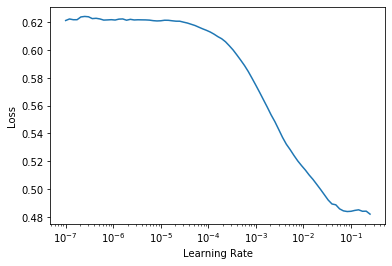

In [ ]:
learn.lr_find()

See some comparisons in the training speed. 

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.558374,0.625199,0.766585,00:00
1,0.462899,0.516987,0.776413,00:00
2,0.419676,0.467384,0.794533,00:00
3,0.396523,0.439086,0.810197,00:00
4,0.382978,0.411233,0.826167,00:00


With the optimized batch size, training is almost instantaneous.

In contrast, with default batch size:

In [ ]:
learn.dls = dls
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.369608,0.358464,0.833692,00:04
1,0.347242,0.358608,0.835074,00:04
2,0.347959,0.351834,0.839220,00:04
3,0.343089,0.346979,0.842291,00:04
4,0.333152,0.347157,0.842138,00:04


We have an infinite speed increase :D

Just remember, this batch size is optimized for training speed but may not minimaze the validation error. Regardless, it gives you a reference to the max batch size to use.